<a href="https://colab.research.google.com/github/jd2504/bme_dsp_2025/blob/main/11_causal_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal inference

In [1]:
import os
import sys

bme_repo = "https://github.com/jd2504/bme_dsp_2025.git"
repo_name = bme_repo.split('/')[-1].replace('.git', '')
!git clone {bme_repo}
sys.path.append(os.path.join(os.getcwd(), repo_name))
import bmedsp_helpers as bme

Cloning into 'bme_dsp_2025'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 112 (delta 51), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (112/112), 5.79 MiB | 8.14 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [2]:
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
# from scipy import stats


from matplotlib import pyplot as plt

In [3]:
x = bme.grab_mat('cause_or_confound.mat')

https://parralab.org/teaching/biomed-dsp/cause_or_confound.mat
dict_keys(['__header__', '__version__', '__globals__', 'X', 'Y', 'Z'])
b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Apr 28 11:57:53 2022'


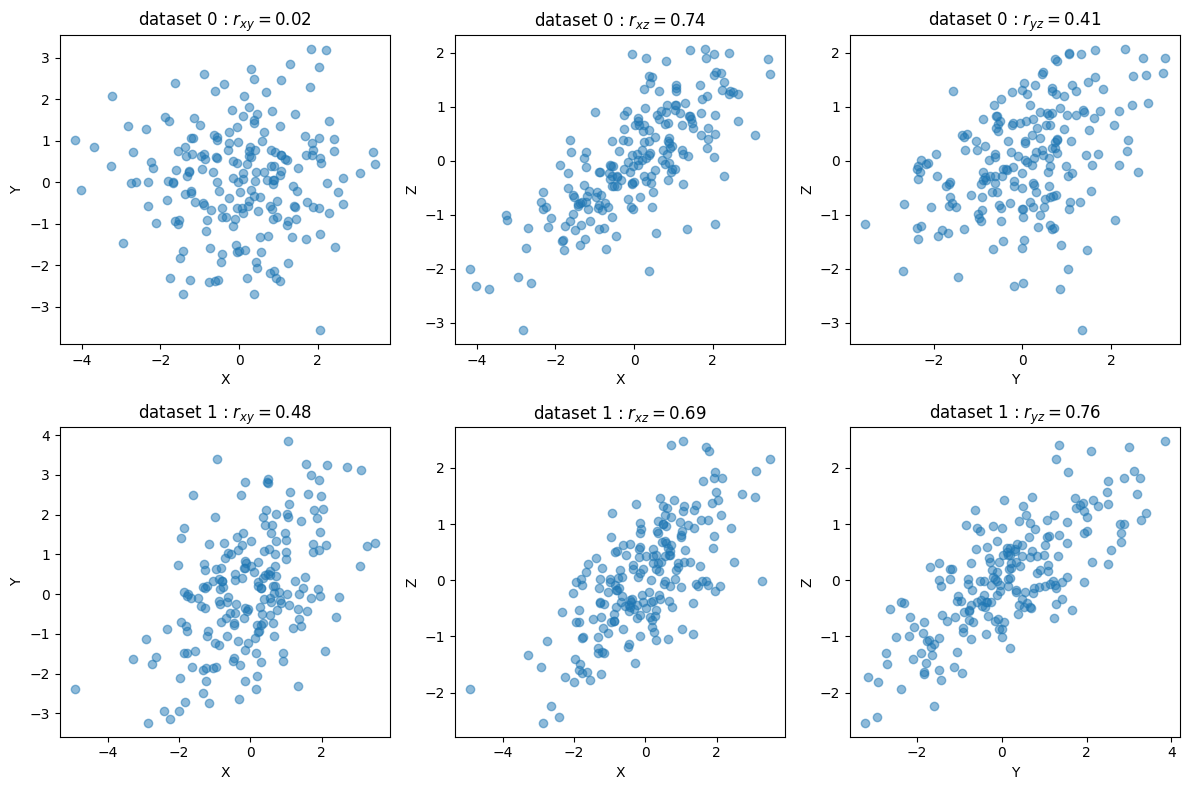

In [4]:
from itertools import combinations

plt.figure(figsize=(12,8))

def plt_corr(data, vars, set_n, plot_n):
    plt.subplot(2,3,plot_n)
    v1, v2 = data[vars[0]][:,set_n], data[vars[1]][:,set_n]

    r = np.corrcoef(v1,v2)[0,1]
    plt.plot(v1,v2,'o',alpha=0.5)
    subplot_title = "r_{" + str(vars[0]+vars[1]).lower()+"}=" + str(float(round(r,2)))
    plt.title(f"dataset {set_n} : "+f"${subplot_title}$")
    plt.xlabel(vars[0])
    plt.ylabel(vars[1])


plt_i = 1
for var in combinations(['X','Y','Z'],2):
    plt_corr(x, var,0, plt_i)
    plt_corr(x, var,1, plt_i+3)
    plt_i+=1

plt.tight_layout()
plt.show()

In [5]:
def fit_ols(regressors, dep_var):
    params_output = {}
    m = sm.OLS(dep_var, regressors)
    results = m.fit()
    params_output = list([results.params[1:].tolist(), results.pvalues[1:].tolist()])
    return results, params_output

models = {}
m_params = {}
m_params['info'] = """Dataset > model > {element_1: b coeffs, element_2: b p-value}"""

for i in range(2):
    X, Y, Z = x['X'][:,i], x['Y'][:,i], x['Z'][:,i]
    models[i] = {}
    m_params[i] = {}

    model = 'zx' # test potential confound on independent var
    models[i][model], m_params[i][model] = fit_ols(sm.add_constant(Z), X)

    model = 'zy' # test confound on dependent var
    models[i][model], m_params[i][model] = fit_ols(sm.add_constant(Z), Y)

    model = 'xy'
    models[i][model], m_params[i][model] = fit_ols(sm.add_constant(X), Y)

    model = 'zxy' # control for confound
    models[i][model], m_params[i][model] = fit_ols(sm.add_constant(np.column_stack((Z,X))), Y)

In [6]:
def model_summary(set_n, model, full=True, models_dict=models):
    if full:
        return models_dict[set_n][model].summary()
    else:
        return models_dict[set_n][model].summary().tables[1]

# Results

In [7]:
m_params

{'info': 'Dataset > model > {element_1: b coeffs, element_2: b p-value}',
 0: {'zx': [[1.0673204880002136], [9.200226767136312e-36]],
  'zy': [[0.5192777252118206], [1.9411223757084694e-09]],
  'xy': [[0.017232015063070472], [0.7831657417107701]],
  'zxy': [[1.102439724958743, -0.5463794673702593],
   [1.267278550913733e-19, 9.824700473026987e-12]]},
 1: {'zx': [[0.9536504468447411], [2.8272003893881654e-29]],
  'zy': [[1.1512965971111468], [1.2840718736364404e-38]],
  'xy': [[0.5216824494497312], [9.49405542529757e-13]],
  'zxy': [[1.2383346183672255, -0.09126826453450804],
   [1.0194589005575543e-27, 0.19163092690348865]]}}

In [8]:
model_summary(0, 'zx', full=False)

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.0299,0.069,0.431,0.667,-0.107,0.167
x1,1.0673,0.069,15.421,0.000,0.931,1.204


## Dataset 1

- $X$ & $Y$ assoc. (naive model) appears nonexistant: $\beta_{XY}=0.0172$ ($p=0.783$), and $r_{XY} = 0.02$
- Significant negative assoc. after controlling for confound $Z$: $\beta_{XY}=-0.5464$ ($p=0.000$)
- $Z$ assoc. also significant: $\beta_{ZY}=1.1024$ ($p=0.000$)

$$Z \rightarrow Y (\beta_{ZY}=1.1024)$$
$$ Z \rightarrow X (\r_{XZ}=0.74)$$

$$X \rightarrow Y (\beta_{XY}=-0.5463)$$

$X$ causally affects $Y$, but effect was hidden until confound was accounted for. Adjusted model is significant improvement on naive model ($F=102.22$, $p=0.000$)

In [9]:
anova_lm(models[0]['xy'], models[0]['zxy'])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,198.0,325.780046,0.0,NaN,NaN,NaN
1,197.0,214.485327,1.0,111.294719,102.221723,1.267279e-19


## Dataset 2

- Positive, significant assoc. between $X$ and $Y$: $\beta_{XY}=0.5217$ ($p=0.000$)
- After adjusting for confound $Z$: $\beta_{ZY}=1.2383$ ($p=0.000$) and $\beta_{XY}=-0.0913$ ($p=0.192$)
- $Z$ is common cause to $X$ and $Y$

$$Z \rightarrow Y (\beta_{ZY}=1.2383)$$
$$ Z \rightarrow X (r_{XZ}=0.69)$$

Apparent and spurious effect of $X$ on $Y$ in naive model, disappears when confound accounted for. Adjusted model is significant improvement on naive model ($F=106.04$, $p=0.000$)

In [10]:
anova_lm(models[1]['xy'], models[1]['zxy'])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,198.0,334.657155,0.0,NaN,NaN,NaN
1,197.0,182.603332,1.0,152.053823,164.041931,1.019459e-27


## estimate the loaded data's causal order...

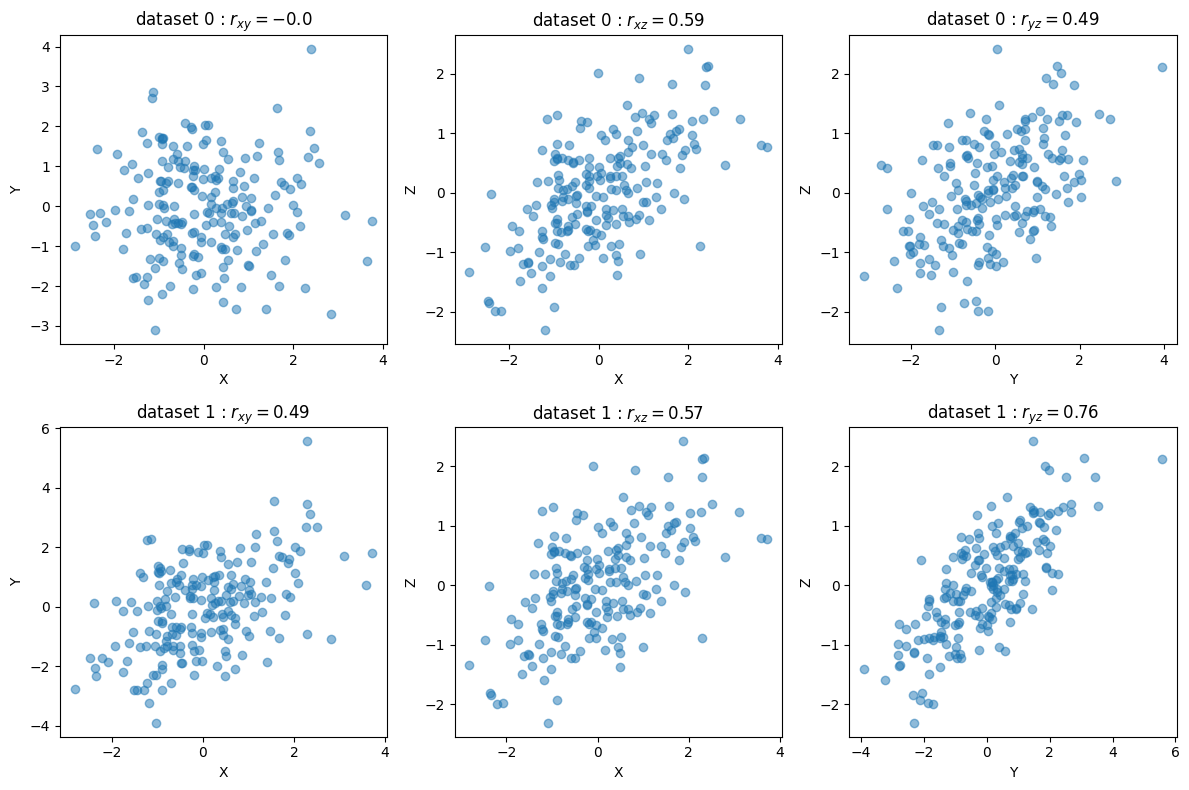

In [11]:
from numpy.random import randn

N = 200

U_z = np.random.randn(N,1) # confound
U_y = np.random.randn(N,1)
U_x = np.random.randn(N,1)


# dataset 1  - Z -> X -> Y
beta_yx_1 = -0.55
beta_xz_1 = 0.74
beta_yz_1 = 1.10
Z1 = U_z
X1 = beta_xz_1 * Z1 + U_x
Y1 = beta_yx_1 * X1 + beta_yz_1 * Z1 + U_y


# dataset 2 - Z common cause
beta_xz_2 = 0.69
beta_yz_2 = 1.24
Z2 = U_z
X2 = beta_xz_2 * Z2 + U_x
Y2 = beta_yz_2 * Z2 + U_y


x_gen = {
    'X': np.column_stack([X1.flatten(), X2.flatten()]),
    'Y': np.column_stack([Y1.flatten(), Y2.flatten()]),
    'Z': np.column_stack([Z1.flatten(), Z2.flatten()]),
}

# same plots with generated data

plt.figure(figsize=(12,8))

def plt_corr(data, vars, set_n, plot_n):
    plt.subplot(2,3,plot_n)
    v1, v2 = data[vars[0]][:,set_n], data[vars[1]][:,set_n]

    r = np.corrcoef(v1,v2)[0,1]
    plt.plot(v1,v2,'o',alpha=0.5)
    subplot_title = "r_{" + str(vars[0]+vars[1]).lower()+"}=" + str(float(round(r,2)))
    plt.title(f"dataset {set_n} : "+f"${subplot_title}$")
    plt.xlabel(vars[0])
    plt.ylabel(vars[1])


plt_i = 1
for var in combinations(['X','Y','Z'],2):
    plt_corr(x_gen, var,0, plt_i)
    plt_corr(x_gen, var,1, plt_i+3)
    plt_i+=1

plt.tight_layout()
plt.show()